# pyfssa Tutorial

## Preamble

In [1]:
from __future__ import division

In [24]:
# configure plotting
%config InlineBackend.rc = {'figure.dpi': 300, 'savefig.dpi': 300, \
                            'figure.figsize': (6, 6 / 1.6), 'font.size': 12, \
                            'figure.facecolor': (1, 1, 1, 0)}
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# configure plotting colors
colors = [
    '#0e5a94',
    '#eb008a',
    '#37b349',
    '#f29333',
    '#00aabb',
    '#b31e8d',
    '#f8ca12',
    '#7a2d00',
]
mpl.rcParams['axes.color_cycle'] = colors

import itertools

In [25]:
import fssa

## A mock scaling function

In this tutorial, we will demonstrate the *pyfssa* routines with a mock scaling function
\begin{equation}
\tilde{f}(x) = e^{-(x+1)^2}
\end{equation}

In [26]:
def mock_scaling_f(x):
    """Mock scaling function"""
    return np.exp(-(x + 1.0)**2)

In [27]:
x = np.linspace(-4.0, 2.0, num=200)

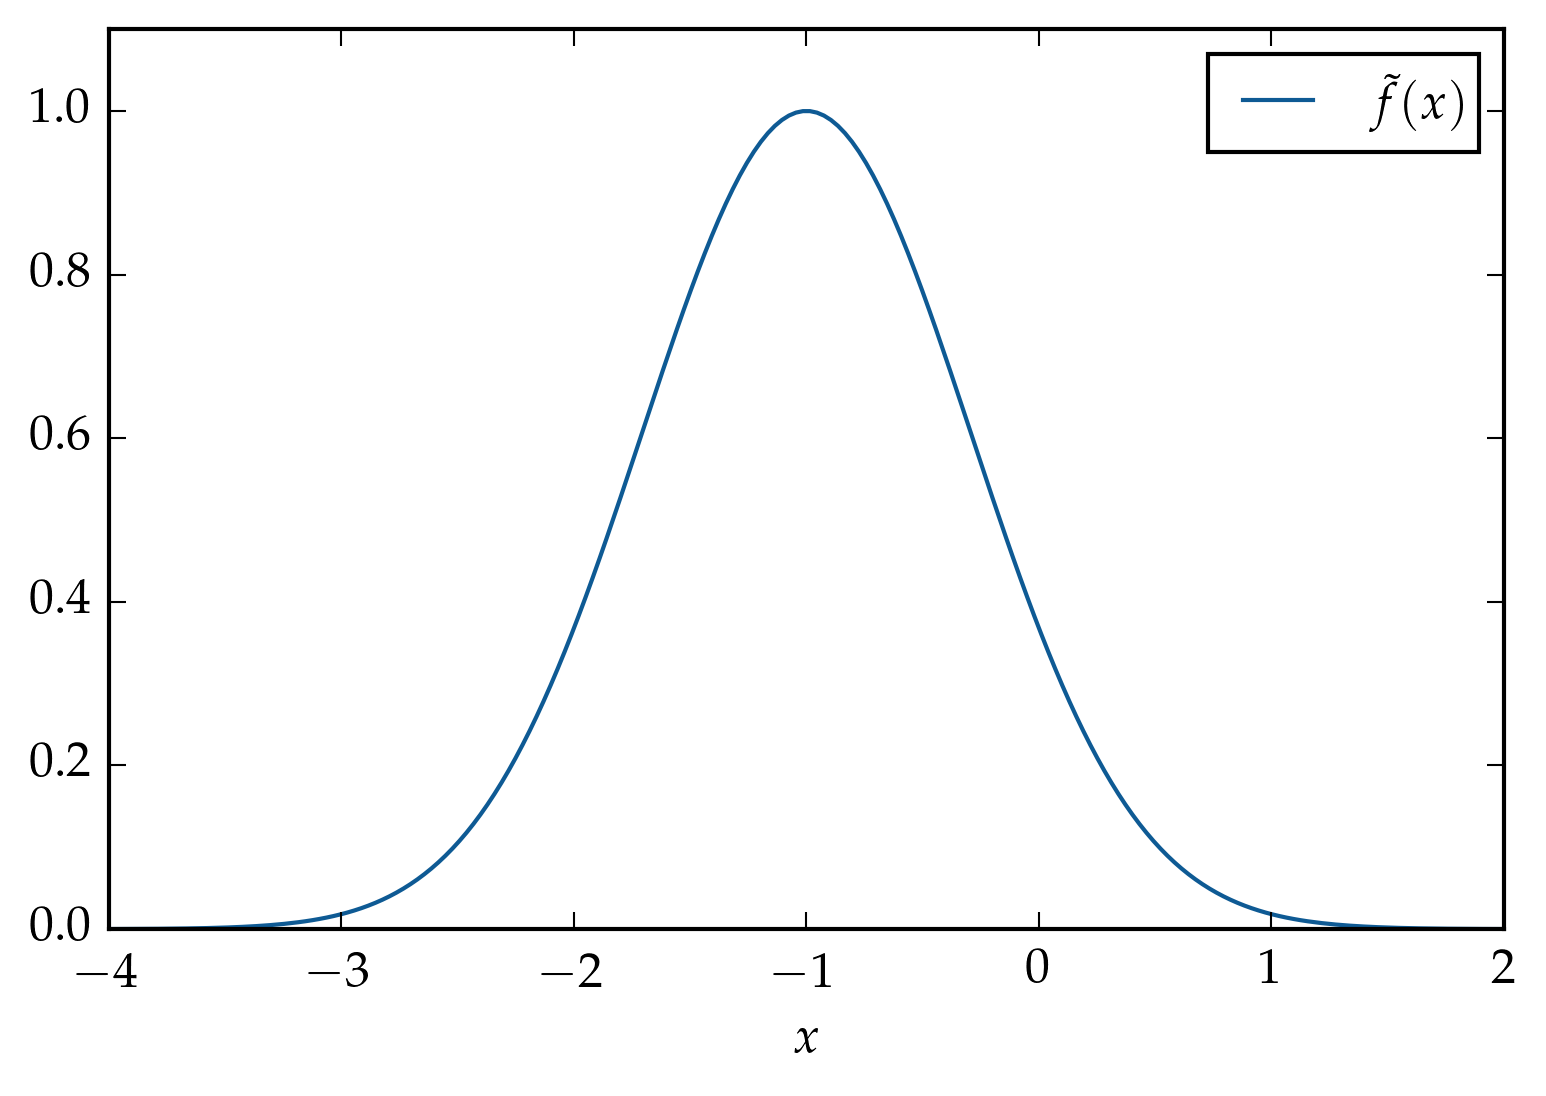

In [28]:
fig, ax = plt.subplots()
ax.plot(x, mock_scaling_f(x), label=r'$\tilde{f}(x)$', rasterized=True)
ax.set_xbound(x.min(), x.max())
ax.set_ybound(0.0, 1.1)
ax.set_xlabel(r'$x$')
ax.legend()
plt.show()

**Figure**: Mock scaling function $\tilde{f}(x) = e^{-(x+1)^2}$

## Precisely mocking scaled data

We generate mock observations $a_{L,\varrho}$ according to the finite-size scaling
\begin{equation}
a_{L, \varrho} = L^{\zeta/\nu} \tilde{f}\left(L^{1/\nu} (\varrho -
\varrho_c)\right)
\end{equation}
with mock exponents $\nu = \frac{5}{2}, \zeta=\frac{3}{2}$ and $\rho_c = \frac{1}{2}$.

In [29]:
def mock_scaled_data(l, rho, rho_c=0.5, nu=2.5, zeta=1.5):
    """Generate scaled data from mock scaling function"""
    return np.transpose(
        np.power(l, zeta / nu) *
        mock_scaling_f(
            np.outer(
                (rho - rho_c), np.power(l, 1 / nu)
            )
        )
    )

In [30]:
rhos = np.linspace(-0.5, 0.8, num=200)
ls = np.logspace(1, 3, num=5).astype(np.int)

In [31]:
# system sizes
ls

array([  10,   31,  100,  316, 1000])

In [32]:
# Generate precisely mocked scaled data
a = mock_scaled_data(ls, rhos)

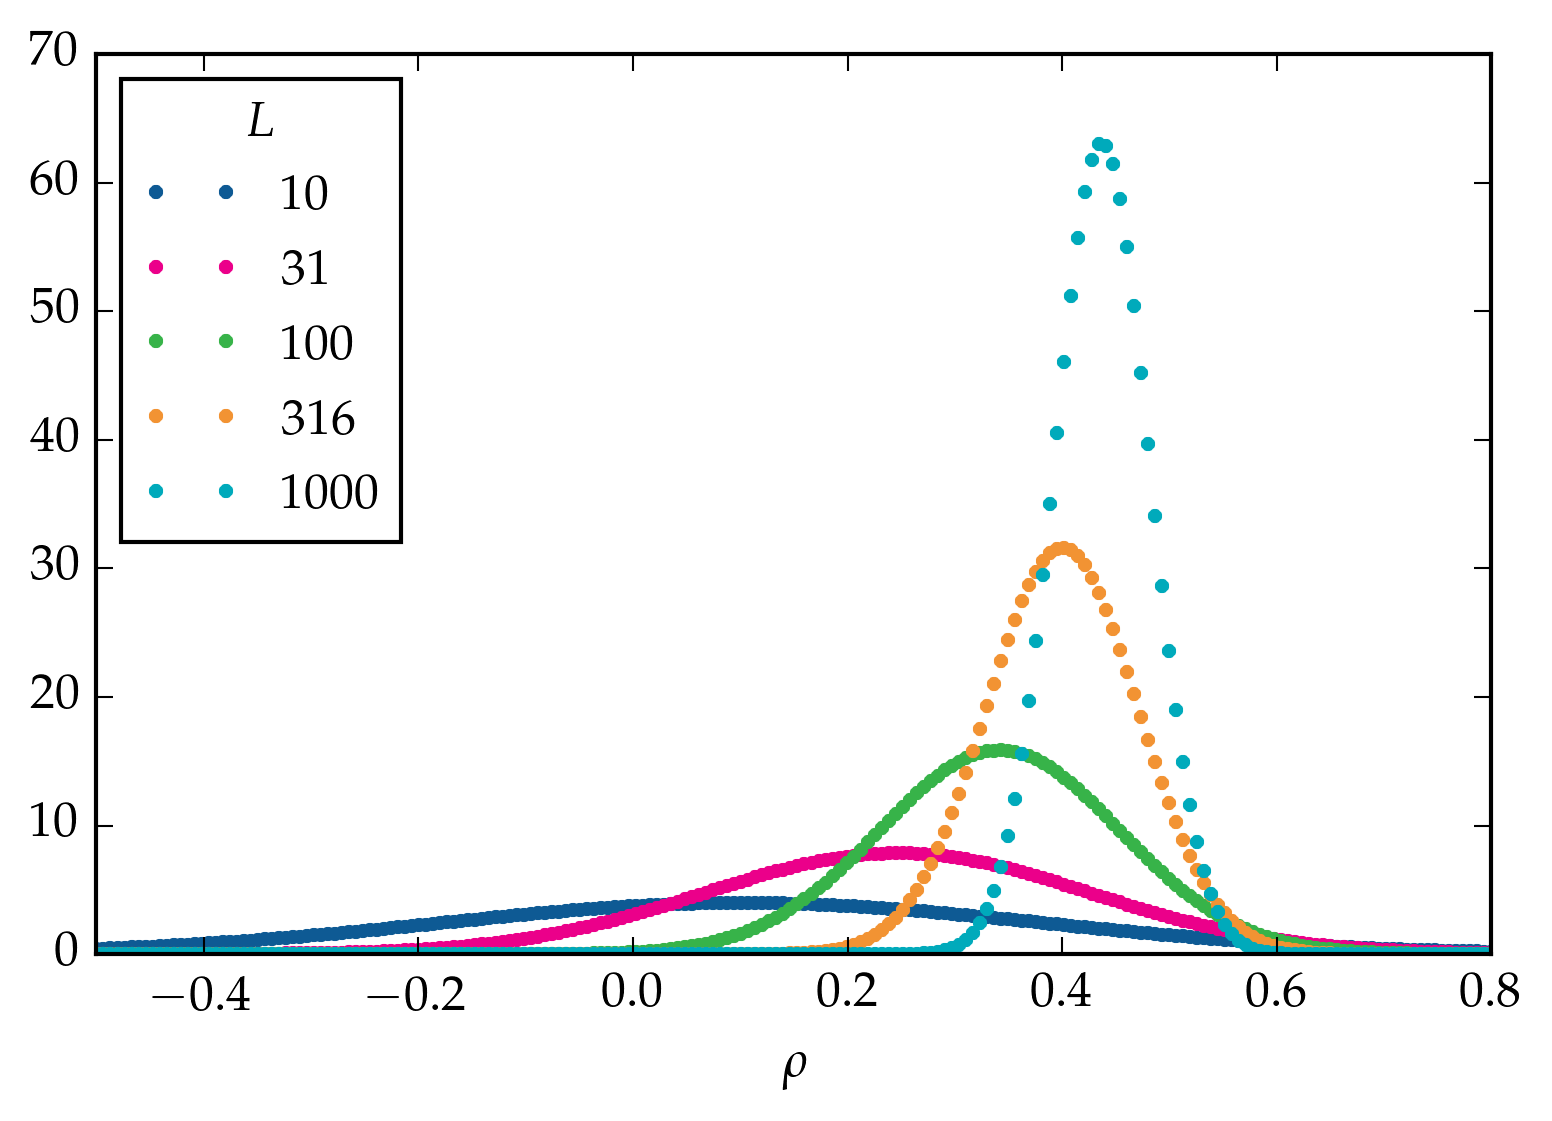

In [36]:
fig, ax = plt.subplots()
for l_index, l in enumerate(ls):
    ax.plot(
        rhos, a[l_index, :],
        '.',
        label=r'${}$'.format(l),
        rasterized=True,
    )
ax.set_xbound(rhos.min(), rhos.max())
ax.set_xlabel(r'$\rho$')
ax.legend(title=r'$L$', loc='upper left')
plt.show()

**Figure**: Mocked raw data, precisely sampled from the scaling function and de-scaled.

## Achieving data collapse with the mock data

Our mock data we now want to scale with the **fssa.scaledata** routine.
We compare the quality of the data collapse of several values for the critical exponents, numerically and graphically.

In [37]:
# Put some relative error bars on the precise data
da = a * 0.1

In [38]:
#a += a * 0.05 * np.random.standard_normal(a.shape)

In [39]:
rho_c = np.tile(0.5, (3, 3))
nu = np.tile(2.5, (3, 3))
zeta = np.tile(1.5, (3, 3))
rho_c[0, :] = [0.25, 0.5, 0.75]
nu[1, :] = [2.0, 2.5, 3.0]
zeta[2, :] = [1.0, 1.5, 2.0]

In [40]:
# re-scale data (manually)
scaled_data = list()
quality = list()
for i in range(3):
    my_scaled_data = list()
    my_quality = list()
    for j in range(3):
        my_scaled_data.append(
            fssa.scaledata(
                ls, rhos, a, da,
                rho_c[i, j], nu[i, j], zeta[i, j]
            )
        )
        my_quality.append(fssa.quality(*my_scaled_data[-1]))
    scaled_data.append(my_scaled_data)
    quality.append(my_quality)

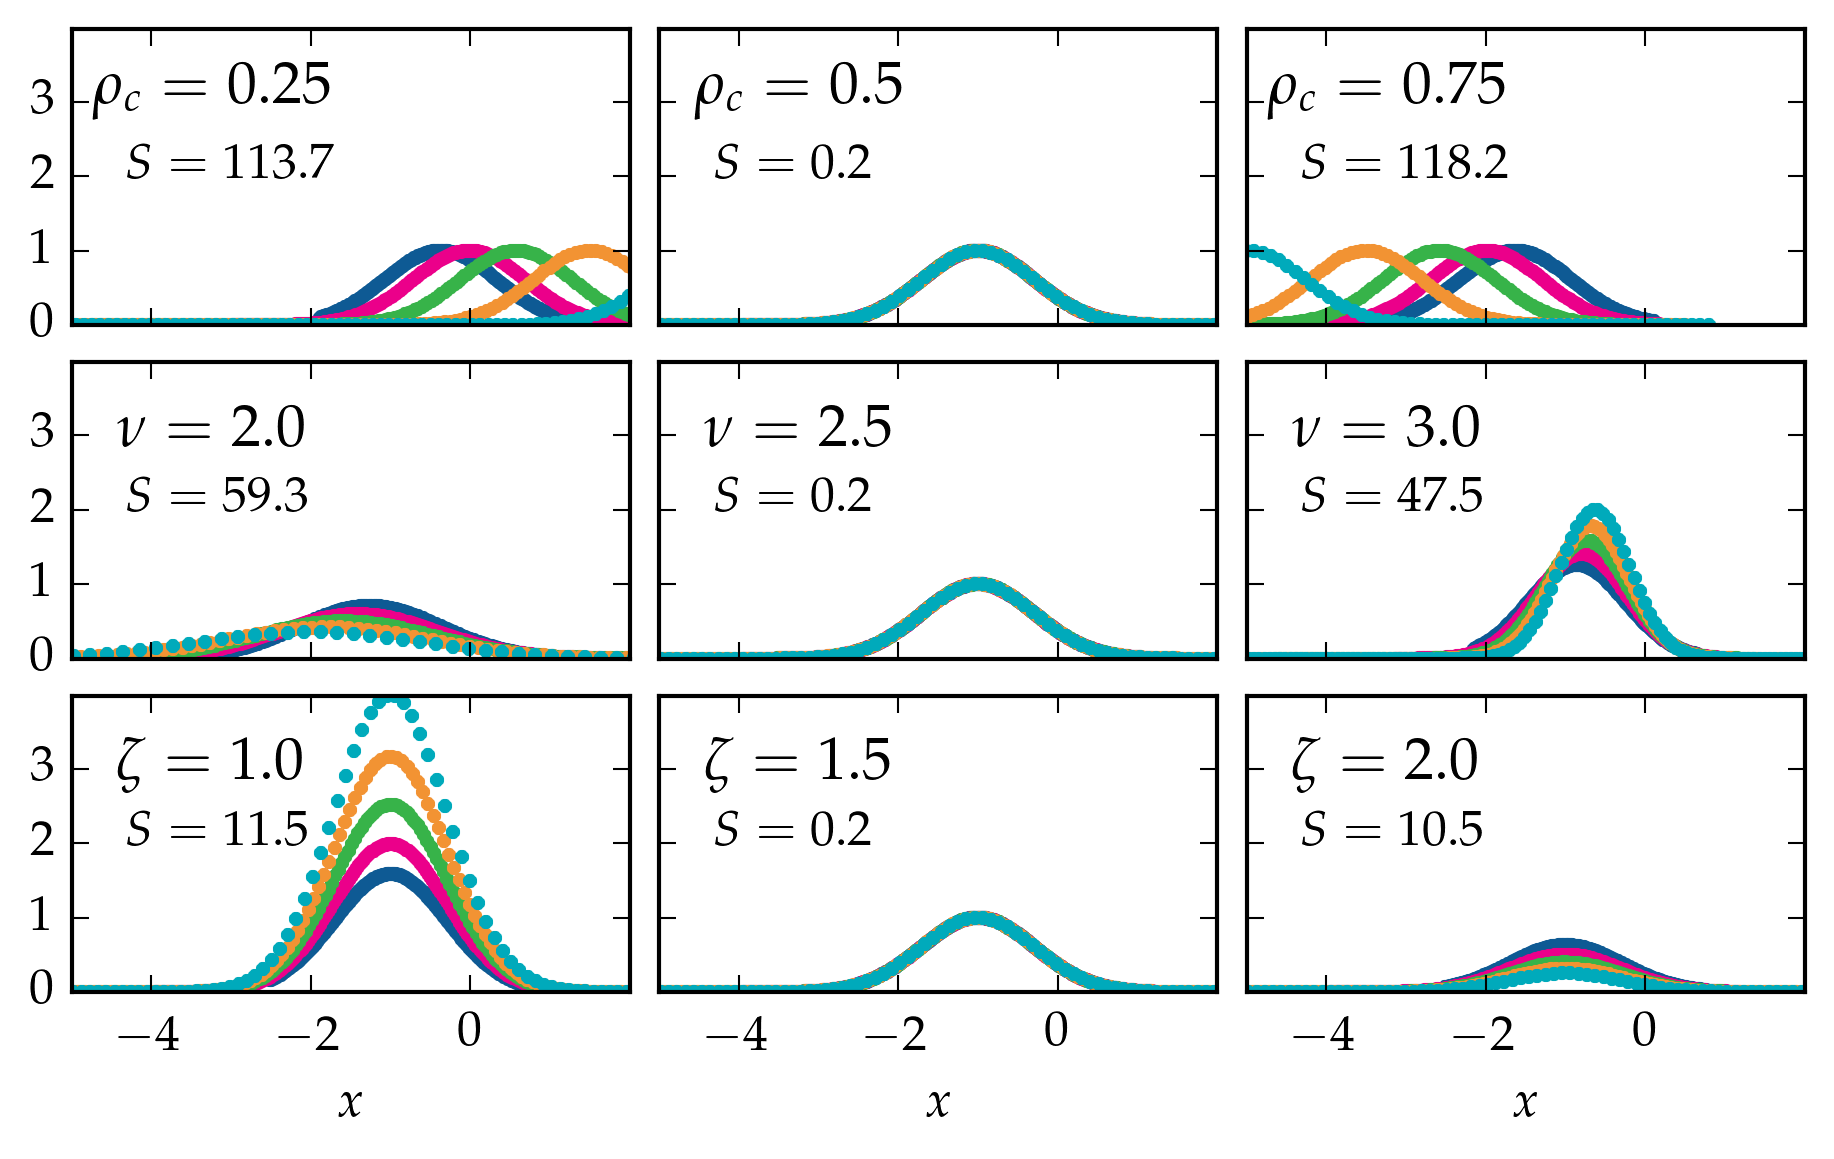

In [66]:
# plot manually re-scaled data
fig, axes = plt.subplots(
    nrows=3, ncols=3, squeeze=True,
    #figsize=(8, 7),
    sharex=True, sharey=True,
)

for (i, j) in itertools.product(range(3), range(3)):
    ax = axes[i, j]
    my_scaled_data = scaled_data[i][j]
    for l_index, l in enumerate(ls):
        ax.plot(
            my_scaled_data.x[l_index, :], my_scaled_data.y[l_index, :],
            '.',
            label=r'${}$'.format(l),
            rasterized=True,
        )
    ax.set_xbound(-5, 2)
    if i == 0:
        ax.set_title(
            r'$\rho_c = {}$'.format(rho_c[i, j]),
            position=(0.25, 0.65),
        )
    elif i == 1:
        ax.set_title(
            r'$\nu = {}$'.format(nu[i, j]),
            position=(0.25, 0.65),
        )
    elif i == 2:
        ax.set_title(
            r'$\zeta = {}$'.format(zeta[i, j]),
            position=(0.25, 0.65),
        )
    if i == 2:
        ax.set_xlabel(r'$x$')
        ax.set_xticks([-4, -2, 0, ])
    if j == 0:
        ax.set_yticks([0, 1, 2, 3, 4, 5])
    ax.text(
        0.1, 0.5,
        r'$S={:.1f}$'.format(quality[i][j]),
        transform=ax.transAxes,
    )

#axes[1, 1].legend(title=r'$L$')

plt.tight_layout(0.25)
plt.show()

**Figure**: Scaling the mock data with varying exponents. The true exponents are in the middle column as the critical parameter $\rho_c = \frac{1}{2}$ and $\nu = \frac{5}{2}$, $\zeta = \frac{3}{2}$, as signified by the data collapse onto the single master curve and the quality-of-fit $S$ (smaller is better).

## Auto-scaling the mock data

Now that we have an idea of the approximate range of the exponents, we employ the *fssa.autoscale* function to algorithmically determine accurate values and their errors.

In [67]:
ret = fssa.autoscale(ls, rhos, a, da, 0.4, 1.8, 2.2)

In [68]:
ret

  errors: array([ 0.00295211,  0.01376928,  0.06224158])
       x: array([ 0.50066146,  2.50622961,  1.49742719])
  status: 0
    drho: 0.0029521052805776349
    zeta: 1.497427191104576
     fun: 0.15575986252960441
   dzeta: 0.062241579700534462
     nit: 39
     rho: 0.50066146345271489
      nu: 2.5062296089038192
    fsim: array([ 0.15575986,  0.15602201,  0.15705568,  0.15748661])
 success: True
     dnu: 0.013769278850417857
   varco: array([[  8.71492559e-06,   3.61453572e-05,  -2.48287344e-05],
       [  3.61453572e-05,   1.89593040e-04,  -2.35933612e-04],
       [ -2.48287344e-05,  -2.35933612e-04,   3.87401424e-03]])
 message: 'Optimization terminated successfully.'
     sim: array([[ 0.50066146,  2.50622961,  1.49742719],
       [ 0.50008949,  2.50321527,  1.50705644],
       [ 0.50003664,  2.50277757,  1.49774815],
       [ 0.50001366,  2.50464067,  1.49252043]])
    nfev: 80

In [69]:
auto_scaled_data = fssa.scaledata(ls, rhos, a, da, ret.rho, ret.nu, ret.zeta)

In [70]:
# critical exponents and errors, quality of data collapse
print(ret.rho, ret.drho)
print(ret.nu, ret.dnu)
print(ret.zeta, ret.dzeta)
print(ret.fun)

0.500661463453 0.00295210528058
2.5062296089 0.0137692788504
1.4974271911 0.0622415797005
0.15575986253


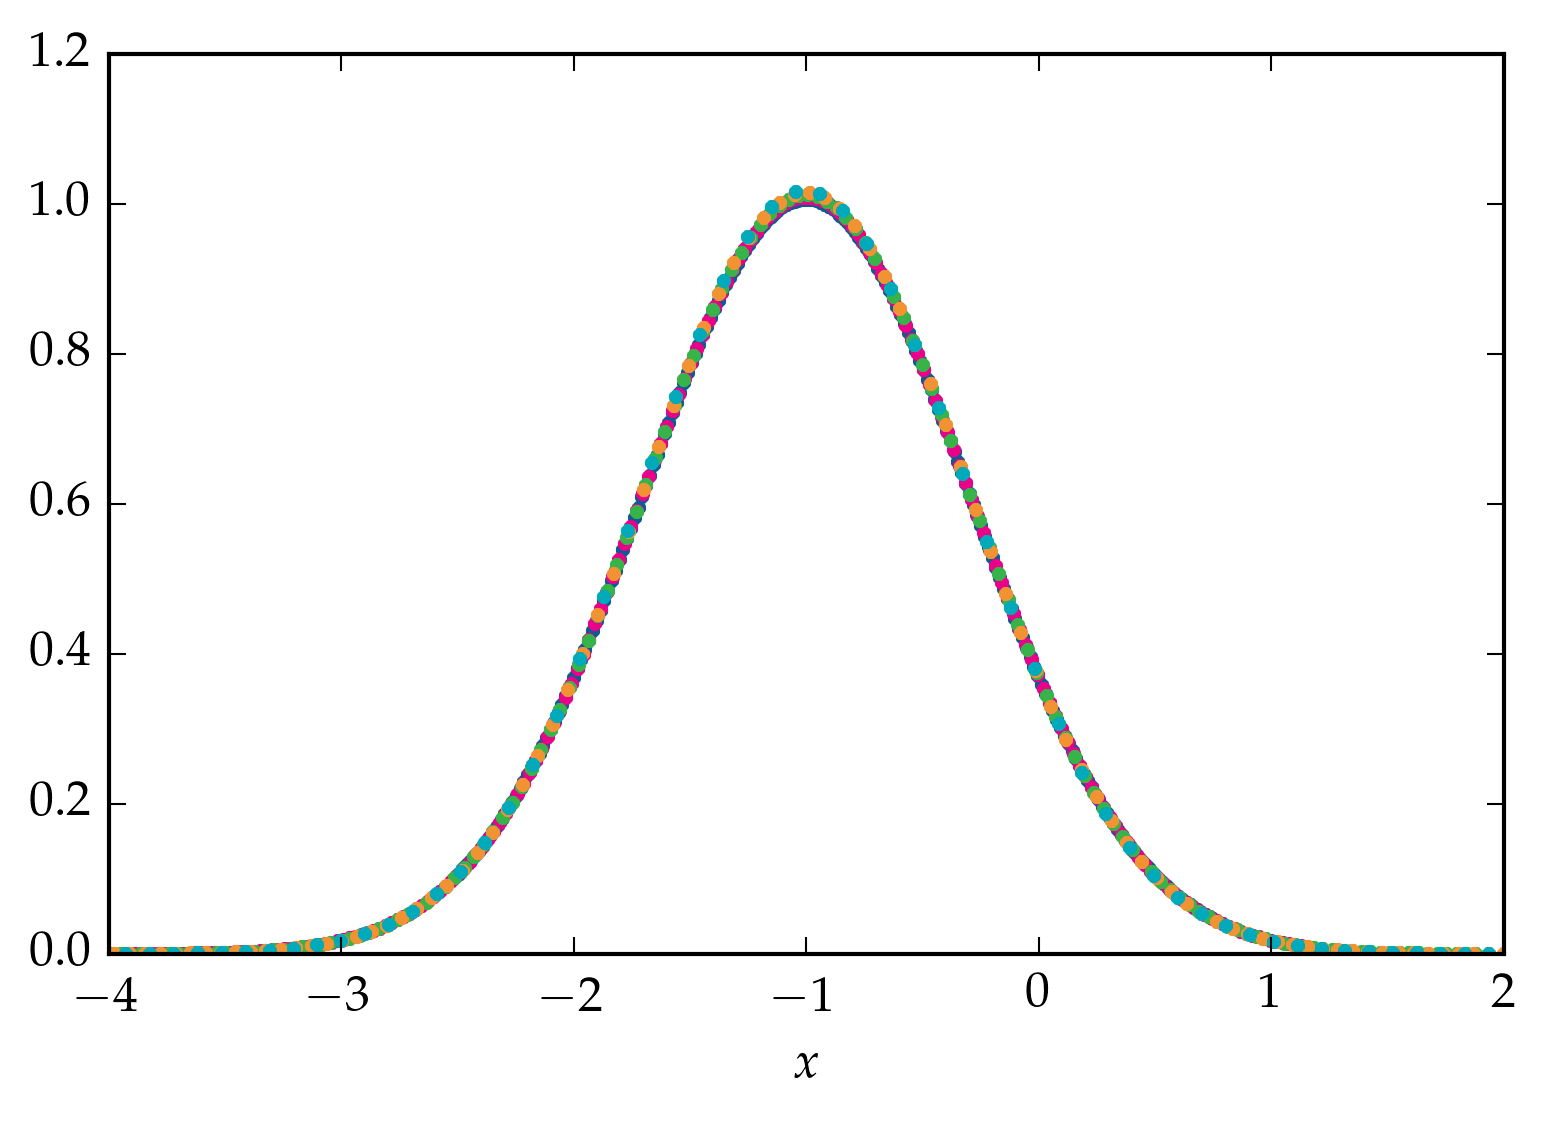

In [71]:
fig, ax = plt.subplots()
ax.plot(
    auto_scaled_data.x.T, auto_scaled_data.y.T,
    '.',
)
ax.set_xbound(-4, 2)
ax.set_xlabel(r'$x$')
plt.show()

**Figure**: Auto-scaling with *pyfssa* leads to data collapse of the mock data onto the original scaling function.